# CNN based model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import zipfile

In [ ]:
# Upload your archive.zip to the Colab file explorer first
zip_path = '/content/archive.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")

Extraction complete.


## Preprocess

In [ ]:
import shutil
import os

# 1. Define Paths
original_base = '/content/dataset/Potato Disease Recognition Dataset/Original Images/Original Images'
augmented_base = '/content/dataset/Potato Disease Recognition Dataset/Augmented Images/Augmented Images'
combined_base = '/content/combined_dataset'

# The base names (matching your original folders)
classes = [
    'Potato Soft Rot Disease',
    'Potato Dry Rot Disease',
    'Potato Brown Rot Disease',
    'Healthy Potato',
    'Blackspot Bruising Disease'
]

# 2. Create Combined Folders and Copy Files
for cls in classes:
    # Create a clean folder in the 'combined' directory
    os.makedirs(os.path.join(combined_base, cls), exist_ok=True)

    # Path to original folder
    orig_folder = os.path.join(original_base, cls)

    # Path to augmented folder (adding the "Augmented " prefix here)
    aug_folder = os.path.join(augmented_base, f"Augmented {cls}")

    # Copy original images (if the folder exists)
    if os.path.exists(orig_folder):
        for img in os.listdir(orig_folder):
            shutil.copy(os.path.join(orig_folder, img), os.path.join(combined_base, cls, f"orig_{img}"))

    # Copy augmented images (if the folder exists)
    if os.path.exists(aug_folder):
        for img in os.listdir(aug_folder):
            shutil.copy(os.path.join(aug_folder, img), os.path.join(combined_base, cls, f"aug_{img}"))

print("Sukses")


Sukses


In [ ]:
# 3. Load the Combined Dataset using TensorFlow
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
    combined_base,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    combined_base,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print(f"Classes found and merged: {class_names}")

Found 3960 files belonging to 5 classes.
Using 3168 files for training.
Found 3960 files belonging to 5 classes.
Using 792 files for validation.
Classes found and merged: ['Blackspot Bruising Disease', 'Healthy Potato', 'Potato Brown Rot Disease', 'Potato Dry Rot Disease', 'Potato Soft Rot Disease']


## Pembuatan model CNN dan Training Model

In [ ]:
num_classes = len(class_names)

model = models.Sequential([
    # Layer 1: Rescaling (Normalisasi pixel dari 0-255 menjadi 0-1)
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Layer 2: Convolutional & Pooling
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Layer 3: Convolutional & Pooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Layer 4: Convolutional & Pooling
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Layer 5: Flattening & Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Mencegah overfitting
    layers.Dense(num_classes, activation='softmax') # Output layer
])

# Compile Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,621 (56.61 MB)

 Trainable params: 14,839,621 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20

print("Memulai pelatihan model...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Memulai pelatihan model...
Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 470s 5s/step - accuracy: 0.4114 - loss: 1.6683 - val_accuracy: 0.6970 - val_loss: 0.8155
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 505s 5s/step - accuracy: 0.6188 - loss: 0.9492 - val_accuracy: 0.7083 - val_loss: 0.7233
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 471s 5s/step - accuracy: 0.6836 - loss: 0.7882 - val_accuracy: 0.7323 - val_loss: 0.6499
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/step - accuracy: 0.7370 - loss: 0.6496 - val_accuracy: 0.7563 - val_loss: 0.6418
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 504s 5s/step - accuracy: 0.7616 - loss: 0.6051 - val_accuracy: 0.7854 - val_loss: 0.5617
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 497s 5s/step - accuracy: 0.7705 - loss: 0.5579 - val_accuracy: 0.7765 - val_loss: 0.5781
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 521s 5s/step - accuracy: 0.8550 - loss: 0.3798 - val_accuracy: 0.7298 - val_loss: 0.8701
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 477s 5s/step - accuracy: 0.8680 - loss: 0.3503

## Evaluasi Hasil Training

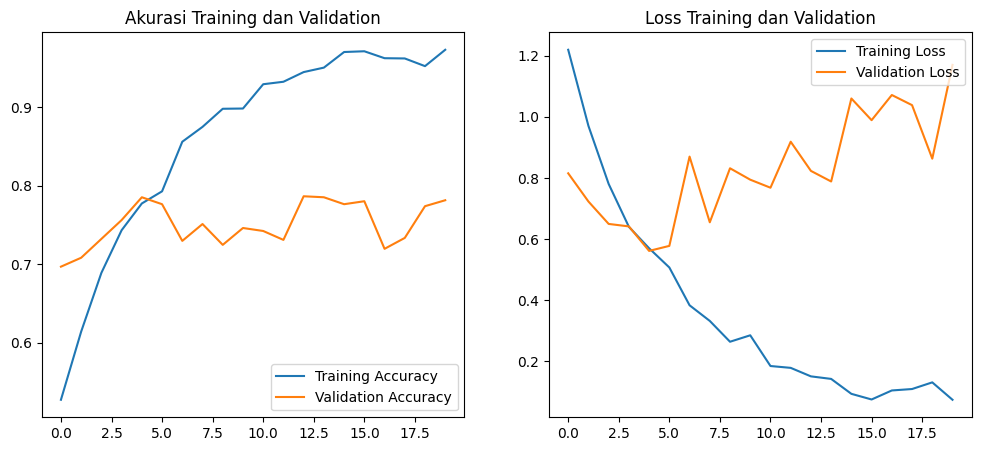

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Akurasi Training dan Validation')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss Training dan Validation')
plt.legend(loc='upper right')

plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Inisialisasi list
y_true = []
y_pred = []

print("Sedang mengumpulkan prediksi dari data validasi... (mohon tunggu)")

# Loop melalui data validasi
for images, labels in val_ds:
    # Simpan label asli (kebenaran)
    y_true.extend(labels.numpy())

    # Prediksi menggunakan model yang sudah dilatih
    preds = model.predict(images, verbose=0)

    # Ambil index kelas dengan probabilitas tertinggi
    y_pred.extend(np.argmax(preds, axis=1))

print("Selesai! Sekarang variabel y_true dan y_pred sudah siap.")

Sedang mengumpulkan prediksi dari data validasi... (mohon tunggu)
Selesai! Sekarang variabel y_true dan y_pred sudah siap.


In [ ]:
print("Akurasi Detail Per Kategori Penyakit:\n")
# Pastikan class_names sudah didefinisikan di Cell 3 sebelumnya
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

Akurasi Detail Per Kategori Penyakit:

                            precision    recall  f1-score   support

Blackspot Bruising Disease       0.73      0.83      0.77       174
            Healthy Potato       0.97      0.93      0.95       164
  Potato Brown Rot Disease       0.00      0.00      0.00        22
    Potato Dry Rot Disease       0.74      0.89      0.81       307
   Potato Soft Rot Disease       0.76      0.40      0.52       125

                  accuracy                           0.78       792
                 macro avg       0.64      0.61      0.61       792
              weighted avg       0.77      0.78      0.76       792



## Penyimpanan hasil data model kedalam H5

In [ ]:
# Simpan model
model_name = 'potato_disease_model.h5'
model.save(model_name)
print(f"Model berhasil disimpan sebagai {model_name}")

# Download model ke komputer lokal
from google.colab import files
files.download(model_name)

Model berhasil disimpan sebagai potato_disease_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json

# Simpan class names ke file JSON
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

files.download('class_names.json')
print("Daftar kelas berhasil diunduh!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Daftar kelas berhasil diunduh!
